In [26]:
import scanpy as sc
import scvi
import pandas as pd

# gene expression

## preprocessing

In [27]:
# data source: # https://www.biorxiv.org/content/10.1101/2025.09.11.675724v1.full - PacBio long reads
# files paths 

CARMELLE_DATA_DIR = "/mnt/lareaulab/carmelle/longread_sc/lung"
AATH_DATA_DIR = "/Users/aathreyakadambi/Documents/school/berkeley/fa25/cs194/final_project/data"
DATA_DIR = AATH_DATA_DIR

# sn
sn_gene = f'{DATA_DIR}/sn/GSM9135509_pb_sn_genes_count_matrix.tsv.gz'
sn_isoform = f'{DATA_DIR}/sn/GSM9135509_pb_sn_transcript_count_matrix.mtx.gz'

# sc
sc_gene = f'{DATA_DIR}/sc/GSM9135508_pb_sc_genes_count_matrix.tsv.gz'
sc_isoform = f'{DATA_DIR}/sc/GSM9135508_pb_sc_transcript_count_matrix.mtx.gz'

In [28]:
adata_sn_gene = sc.read_csv(sn_gene).transpose()
adata_sc_gene = sc.read_csv(sc_gene).transpose()

In [29]:
adata_sn_gene, adata_sc_gene

(AnnData object with n_obs × n_vars = 10001 × 49671,
 AnnData object with n_obs × n_vars = 5002 × 50394)

In [30]:
adata_sn_gene.var_names, adata_sc_gene.var_names

(Index(['ENSG00000211952.3', 'ENSG00000211955.2', 'ENSG00000211956.2',
        'ENSG00000211957.2', 'ENSG00000211958.2', 'ENSG00000211959.2',
        'ENSG00000231475.3', 'ENSG00000238275.2', 'ENSG00000253240.1',
        'ENSG00000253325.1',
        ...
        'ENSG00000283791.1', 'ENSG00000285533.4', 'ENSG00000286756.3',
        'ENSG00000289259.2', 'ENSG00000289339.2', 'ENSG00000289740.1',
        'ENSG00000289883.1', 'ENSG00000290026.1', 'ENSG00000290061.1',
        'ENSG00000291174.1'],
       dtype='object', length=49671),
 Index(['ENSG00000212380.1', 'ENSG00000270814.1', 'ENSG00000280234.1',
        'ENSG00000211938.2', 'ENSG00000211943.2', 'ENSG00000211947.2',
        'ENSG00000211949.3', 'ENSG00000211950.2', 'ENSG00000211952.3',
        'ENSG00000211955.2',
        ...
        'ENSG00000210174.1', 'ENSG00000210176.1', 'ENSG00000210184.1',
        'ENSG00000210191.1', 'ENSG00000210194.1', 'ENSG00000210195.2',
        'ENSG00000210196.2', 'ENSG00000211459.2', 'ENSG00000212907.2'

### check some qc metrics

In [31]:
sc.pp.calculate_qc_metrics(adata_sc_gene, inplace=True)
sc.pp.calculate_qc_metrics(adata_sn_gene, inplace=True)

In [32]:
#looks good
adata_sn_gene.obs['n_genes_by_counts'].mean(), adata_sc_gene.obs['n_genes_by_counts'].mean()

(np.float64(4348.82201779822), np.float64(7170.528988404638))

In [35]:
for ad in [adata_sn_gene, adata_sc_gene]:
    sc.pp.calculate_qc_metrics(ad, inplace=True)
    print(ad.obs[['n_genes_by_counts', 'total_counts']].describe())

       n_genes_by_counts  total_counts
count       10001.000000  10001.000000
mean         4348.822018   8717.169922
std          1216.696600   4200.178223
min          1952.000000   3005.000000
25%          3457.000000   5935.000000
50%          4139.000000   7697.000000
75%          5018.000000  10338.000000
max         11471.000000  57100.000000
       n_genes_by_counts   total_counts
count        5002.000000    5002.000000
mean         7170.528988   32370.386719
std          2577.533027   21479.914062
min           166.000000    1915.000000
25%          5500.750000   15447.750000
50%          7418.000000   27981.500000
75%          9084.750000   46002.750000
max         14445.000000  157072.000000


## concatenate datasets

In [33]:
#add batch labels
adata_sn_gene.obs['batch'] = 'single nuclei'
adata_sc_gene.obs['batch'] = 'single cell'


In [11]:
#no repeat barcodes 

adata_sn_gene.obs_names_make_unique()
adata_sc_gene.obs_names_make_unique()

#no repeat features
adata_sn_gene.var_names_make_unique()
adata_sc_gene.var_names_make_unique()


In [12]:
genes_combined = sc.concat([adata_sc_gene, adata_sn_gene], 
                   join='inner', 
                   label='dataset',
                   keys=['single cell', 'single nuclei'])

/Users/aathreyakadambi/Documents/software/python/anaconda/anaconda3/envs/omics/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [13]:
genes_combined

AnnData object with n_obs × n_vars = 15003 × 47134
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'batch', 'dataset'

In [14]:
#no repeat barcodes in integrated dataset

genes_combined.obs_names_make_unique()

In [15]:
genes_combined.obs['n_genes_by_counts'].mean()

np.float64(5289.579084183163)

In [16]:
genes_combined

AnnData object with n_obs × n_vars = 15003 × 47134
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'batch', 'dataset'

In [17]:
genes_combined.obs['batch'].value_counts()

batch
single nuclei    10001
single cell       5002
Name: count, dtype: int64

In [18]:
sc.pp.filter_cells(genes_combined, min_genes=200)
sc.pp.filter_genes(genes_combined, min_cells=3)

#print after filtering
genes_combined

AnnData object with n_obs × n_vars = 15002 × 46294
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'batch', 'dataset', 'n_genes'
    var: 'n_cells'

In [19]:
# run scvi on raw counts
genes_combined.layers['counts'] = genes_combined.X

# visualize without correcting for batch effect

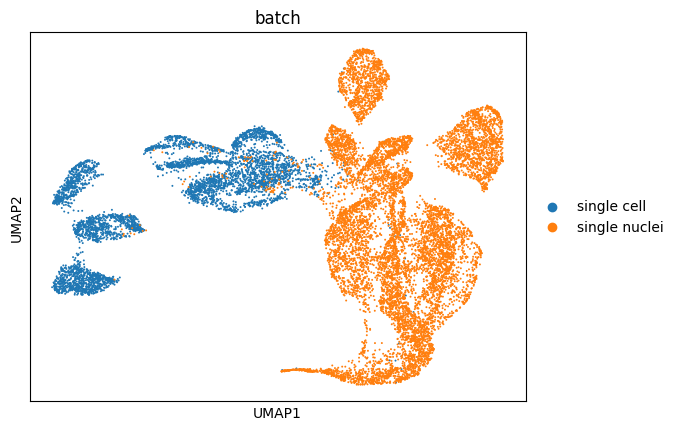

In [20]:
sc.tl.pca(genes_combined)
sc.pp.neighbors(genes_combined, n_pcs=30, n_neighbors=15)
sc.tl.umap(genes_combined, min_dist=0.3)
sc.pl.umap(genes_combined, color=['batch'], wspace=0.55)

# scVI

In [21]:
sc.pp.highly_variable_genes(
    genes_combined,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
)

In [22]:
scvi.model.SCVI.setup_anndata(
    genes_combined,
    layer="counts",
    batch_key="batch",
)

In [23]:
model = scvi.model.SCVI(genes_combined)
model

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

In [24]:
model.train(max_epochs=50,
    accelerator="gpu",
    devices=-1,
    strategy="ddp_notebook_find_unused_parameters_true")

/Users/aathreyakadambi/Documents/software/python/anaconda/anaconda3/envs/omics/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been set to `mps`. Please note that not all PyTorch/Jax operations are supported with this backend. as a result, some models might be slower and less accurate than usuall. Please verify your analysis!Refer to https://github.com/pytorch/pytorch/issues/77764 for more details.
  accelerator, lightning_devices, device = parse_device_args(
/Users/aathreyakadambi/Documents/software/python/anaconda/anaconda3/envs/omics/lib/python3.10/site-packages/scvi/train/_trainrunner.py:81: UserWarning: early_stopping was automaticaly disabled due to the use of DDP
  self.trainer = self._trainer_cls(


ValueError: You set `strategy=ddp_notebook_find_unused_parameters_true` but strategies from the DDP family are not supported on the MPS accelerator. Either explicitly set `accelerator='cpu'` or change the strategy.

In [ ]:
SCVI_LATENT_KEY = "X_scVI"

latent = model.get_latent_representation()
genes_combined.obsm[SCVI_LATENT_KEY] = latent
latent.shape

(15002, 10)

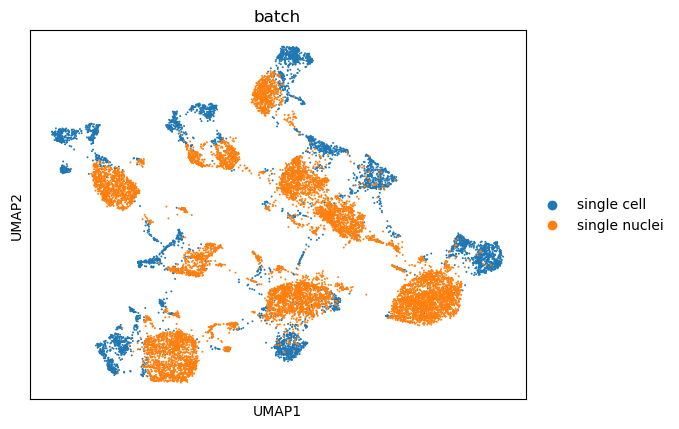

In [ ]:
sc.pp.neighbors(genes_combined, use_rep=SCVI_LATENT_KEY)
sc.tl.umap(genes_combined, min_dist=0.3)
sc.pl.umap(genes_combined, color=['batch'], wspace=0.55)

# integrated data

In [ ]:
genes_combined.write_h5ad('integrated_sc_sn_gene-exp.h5ad')

In [ ]:
genes_combined = sc.read_h5ad('integrated_sc_sn_gene-exp.h5ad')

In [ ]:
genes_combined.obs['n_genes_by_counts'].mean()

np.float64(5289.920610585255)

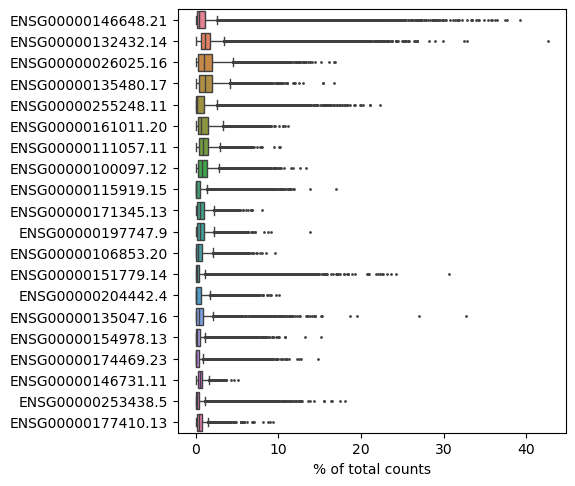

In [ ]:
sc.pl.highest_expr_genes(genes_combined, n_top=20)

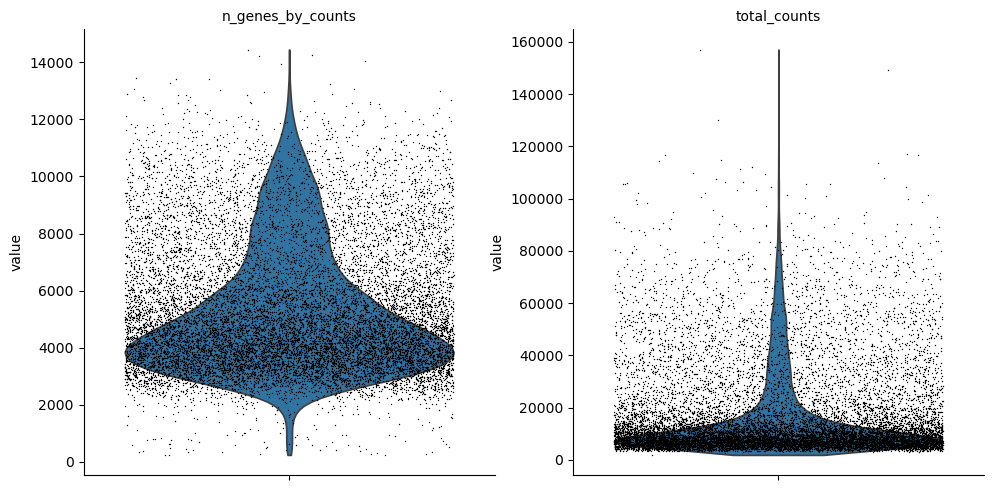

In [ ]:
sc.pl.violin(
    genes_combined,
    ["n_genes_by_counts", "total_counts"],
    jitter=0.4,
    multi_panel=True,
)

# knn

In [ ]:
sc.tl.leiden(genes_combined, resolution=0.2)

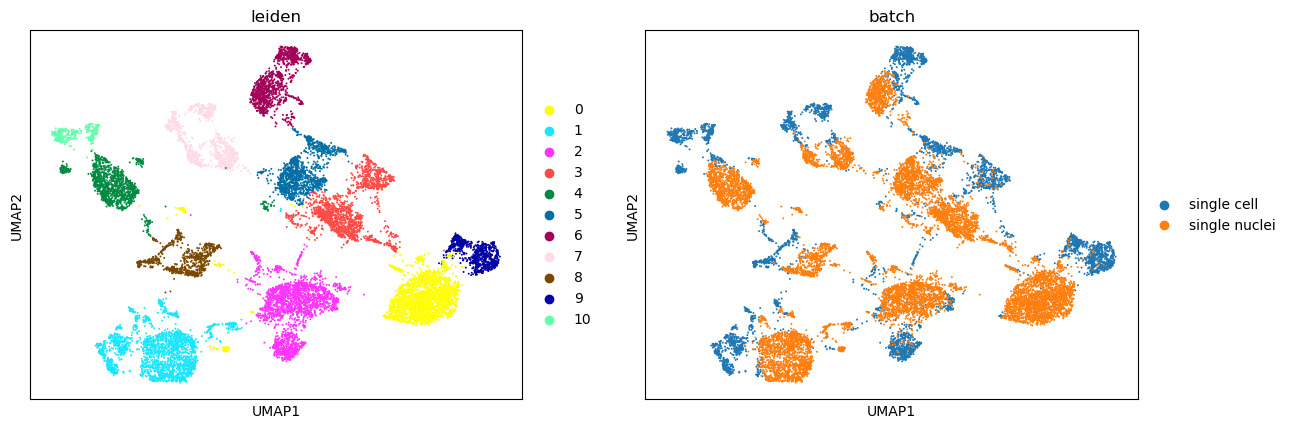

In [ ]:
#visualize

sc.pl.umap(genes_combined, color=['leiden', 'batch'])

In [ ]:
sc.pp.log1p(genes_combined)

In [ ]:
sc.tl.rank_genes_groups(genes_combined, groupby='leiden', method='wilcoxon')

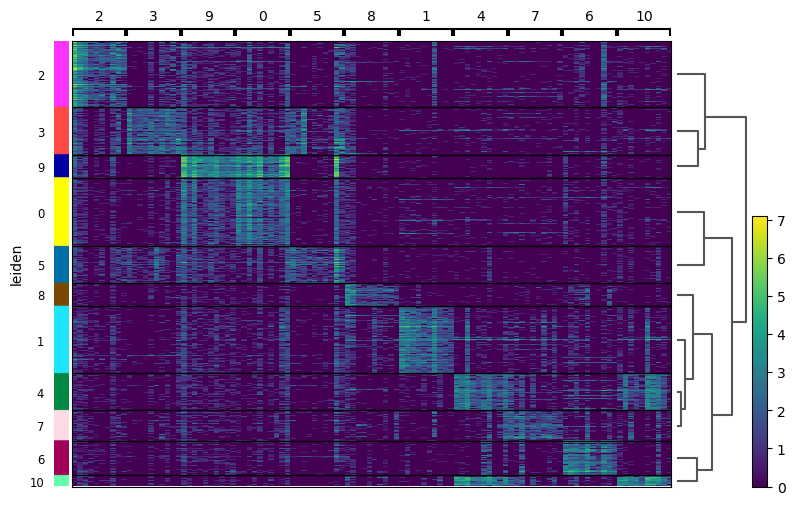

In [ ]:
sc.pl.rank_genes_groups_heatmap(genes_combined, n_genes=10)